<center><img src='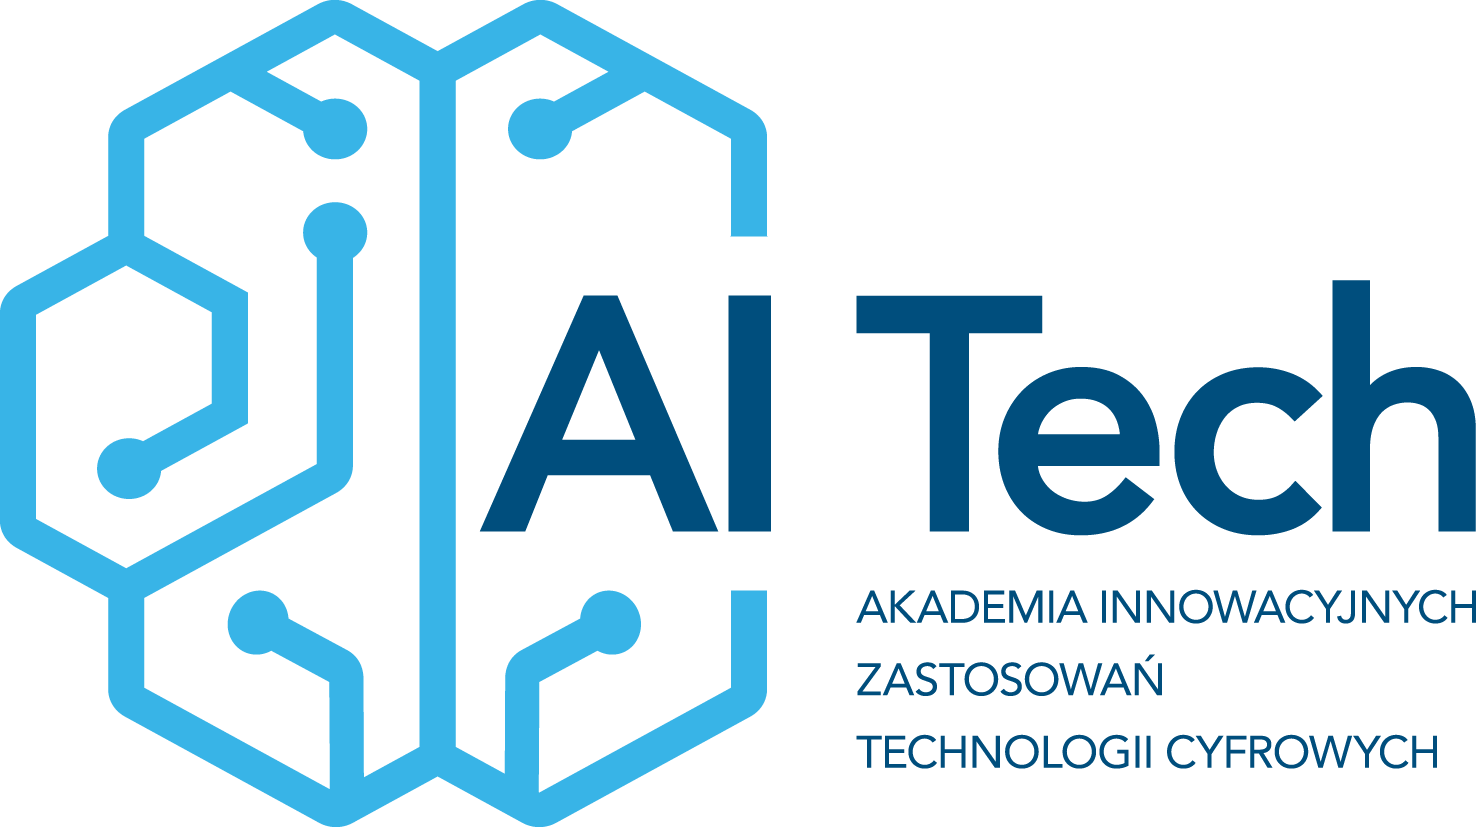
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>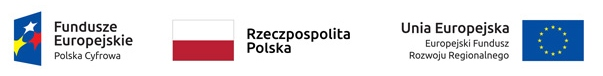</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Tomasz Pawłowski**




# ML in big scale - LAB 10



Stochastic Gradient Descent

* full batch
* mini batch
* mirrored





## Pyspark installation

In [ ]:
!pip install pyspark --quiet
!apt install openjdk-8-jdk-headless &> /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("mlibs") \
                    .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 4.7 MB/s eta 0:00:00


## California housing (1990) dataset

See [link](https://developers.google.com/machine-learning/crash-course/california-housing-data-description?hl=en). For description of the dataset. Data splitted into train and test files in available in:
```
sample_data/california_housing_train.csv
sample_data/california_housing_test.csv
```

### Example 1. Loading data do RDD

In [ ]:
from pyspark import RDD
from typing import TypeVar, Iterable, List, Tuple

T = TypeVar('T')

def drop_header(idx: int, iter: Iterable[T]) -> Iterable[T]:
  if idx == 0:
    next(iter)
  return iter

def parse_lines(line: str) -> List[float]:
  return [float(x) for x in line.split(",")]

TRAIN_RAW = sc.textFile('sample_data/california_housing_train.csv') \
    .mapPartitionsWithIndex(drop_header) \
    .map(parse_lines) \
    .cache()

print(f"train count: {TRAIN_RAW.count()}")
print(TRAIN_RAW.take(10))
FEATURE_LEN = len(TRAIN_RAW.first()) - 1
print(f"no of features {FEATURE_LEN}")

TEST_RAW = sc.textFile('sample_data/california_housing_test.csv') \
    .mapPartitionsWithIndex(drop_header) \
    .map(parse_lines) \
    .cache()

print(f"test count: {TEST_RAW.count()}")
print(TEST_RAW.take(10))

train count: 17000
[[-114.31, 34.19, 15.0, 5612.0, 1283.0, 1015.0, 472.0, 1.4936, 66900.0], [-114.47, 34.4, 19.0, 7650.0, 1901.0, 1129.0, 463.0, 1.82, 80100.0], [-114.56, 33.69, 17.0, 720.0, 174.0, 333.0, 117.0, 1.6509, 85700.0], [-114.57, 33.64, 14.0, 1501.0, 337.0, 515.0, 226.0, 3.1917, 73400.0], [-114.57, 33.57, 20.0, 1454.0, 326.0, 624.0, 262.0, 1.925, 65500.0], [-114.58, 33.63, 29.0, 1387.0, 236.0, 671.0, 239.0, 3.3438, 74000.0], [-114.58, 33.61, 25.0, 2907.0, 680.0, 1841.0, 633.0, 2.6768, 82400.0], [-114.59, 34.83, 41.0, 812.0, 168.0, 375.0, 158.0, 1.7083, 48500.0], [-114.59, 33.61, 34.0, 4789.0, 1175.0, 3134.0, 1056.0, 2.1782, 58400.0], [-114.6, 34.83, 46.0, 1497.0, 309.0, 787.0, 271.0, 2.1908, 48100.0]]
no of features 8
test count: 3000
[[-122.05, 37.37, 27.0, 3885.0, 661.0, 1537.0, 606.0, 6.6085, 344700.0], [-118.3, 34.26, 43.0, 1510.0, 310.0, 809.0, 277.0, 3.599, 176500.0], [-117.81, 33.78, 27.0, 3589.0, 507.0, 1484.0, 495.0, 5.7934, 270500.0], [-118.36, 33.82, 28.0, 67.0, 15

## Exercise 1: Feature scaling

Scale features of the train data uniformly to ranges $[0,1]$

Note use broadcast to 

In [ ]:
import sys
import numpy as np

def get_min_max(x: RDD[List[float]]) -> List[Tuple[float, float]]:
  min = x.reduce(lambda x1, x2: np.min([x1, x2], axis=0))
  max = x.reduce(lambda x1, x2: np.max([x1, x2], axis=0))

  min_max = list(zip(min, max))

  return min_max

def scale_features(x: RDD[List[float]], min_max: List[Tuple[float, float]]) -> RDD[List[float]]:
  min_max = np.array(min_max)

  x = x.map(lambda x: (np.array(x) - min_max[:, 0])/(min_max[:, 1] - min_max[:, 0]))\
       .map(lambda x: x.tolist())
       

  return x

min_max = get_min_max(TRAIN_RAW)
print(min_max)
TRAIN = scale_features(TRAIN_RAW, min_max).cache()
TEST = scale_features(TEST_RAW, min_max).cache()

print(TRAIN.take(10))
print(TEST.take(10))

[(-124.35, -114.31), (32.54, 41.95), (1.0, 52.0), (2.0, 37937.0), (1.0, 6445.0), (3.0, 35682.0), (1.0, 6082.0), (0.4999, 15.0001), (14999.0, 500001.0)]
[[1.0, 0.1753453772582357, 0.27450980392156865, 0.14788453934361406, 0.1989447548106766, 0.028364023655371506, 0.07745436605821411, 0.06853008924014842, 0.10701192984771196], [0.9840637450199207, 0.19766206163655672, 0.35294117647058826, 0.20160801370765782, 0.2948479205462446, 0.03155918047030466, 0.07597434632461766, 0.0910401235845023, 0.13422831246056718], [0.9750996015936255, 0.12221041445270968, 0.3137254901960784, 0.01892711216554633, 0.026846679081315952, 0.009249138148490708, 0.019075809899687553, 0.07937821547289003, 0.14577465659935424], [0.9741035856573714, 0.11689691817215739, 0.2549019607843137, 0.03951495979965731, 0.0521415270018622, 0.01435017797584013, 0.0370004933399112, 0.18563881877491345, 0.12041393643737551], [0.9741035856573714, 0.1094580233793837, 0.37254901960784315, 0.038275998418347175, 0.05043451272501552, 0

## Exercise 2: Loss function

$L(W, x) = \frac{1}{2}(W^{T} x[:-1] - x[-1])^2$

For a given vector of weights $W$ calculate the loss value

In [ ]:
def L(W: List[float], x: List[float]) -> float:
  W = np.array(W)
  x = np.array(x)

  return 1/2 * (W.T @ x[:-1] - x[-1])**2

L([1,2,3], [1,2,3,16])

2.0

In [ ]:
import random 
W = [random.uniform(0.0, 1.0) for i in range(FEATURE_LEN)]
print(W)

[0.3867422876130461, 0.21984822550454264, 0.09665929208717006, 0.47832477285964603, 0.32204323869197926, 0.5582795070733112, 0.47940001769423635, 0.5817311488464352]


In [ ]:
W = [0.8747720421475664, 0.6579597006032682, 0.028436386390033763, 0.03570518459713745, 0.6360996783665139, 0.8737599652195799, 0.1750685984274949, 0.04385799510546551]


## Exercise 3: single step of SGD

Calculate updated weights using the following formula:

$w_i := w_i − \lambda\frac{∂L(W, x_j)}{∂w_i}$

$w[i] := w[i] - \lambda(𝑊^T𝑥[:−1]−𝑥[−1])x[i]$

In [ ]:
def step(l: float, W: List[float], x: List[float]) -> List[float]:
  W = np.array(W)
  x = np.array(x)

  W -= l * (W.T @ x[:-1] - x[-1]) * x[:-1]

  return W

print(step(0.01, W, TRAIN.first()))

[0.8641309  0.65609383 0.02551529 0.03413152 0.63398268 0.87345814
 0.1742444  0.04312876]


## Exercise 4: Total loss of dataset

Given a vector of weights and a RDD calculate the total loss value of the dataset.

$ L(W, X) =  \sum_{x \in X} L(W, x) $ 

Note: broadcast weights list

In [ ]:
def total_loss(W: List[float], x: RDD[List[float]]) -> float:
  losses = x.map(lambda el: L(W, el))

  return losses.sum()

print(total_loss(W, TRAIN))
print(total_loss(step(0.01, W, TRAIN.first()), TRAIN))

1812.8073066331685
1763.4047327734606


## Exercise 5: One iteration of full batch SGD

$w[j] := w[j] - \frac{\lambda}{m} \sum_i^m(𝑊^T𝑥_i[:−1]−𝑥_i[−1])x_i[j]$

In [ ]:
def full_batch_step(l: float, W: List[float], x: RDD[List[float]]) -> List[float]:
  W = np.array(W)
  x = x.map(lambda el: np.array(el))
  m = x.count()

  grads = x.map(lambda xi: l/m * (W.T @ xi[:-1] - xi[-1]) * xi[:-1])
  W = W - grads.reduce(lambda a, b: np.sum([a, b], axis=0))
    
  return W

print(total_loss(W, TRAIN))
print(full_batch_step(0.01, W, TRAIN))
print(total_loss(full_batch_step(0.2, W, TRAIN), TRAIN))

1812.8073066331685
[0.87291634 0.65672201 0.02660521 0.03542394 0.63574856 0.87358675
 0.1747276  0.04323231]
1526.4963137213197


## Exercise 6: One iteration of mini-batch SGD

Use either [pyspark.RDD.sample](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html) or sample each partition independently.

In [ ]:
import random

# p - probability of sampling a row
def mini_batch_step(l: float, W: List[float], x: RDD[List[float]], p: float) -> List[float]:
  # put your code here
  sample = x.sample(True, p)
  return full_batch_step(l, W, sample)

print(total_loss(W, TRAIN))
print(mini_batch_step(0.01, W, TRAIN, 0.2))
print(total_loss(mini_batch_step(0.2, W, TRAIN, 0.2), TRAIN))

1812.8073066331685
[0.87290304 0.65673836 0.02656476 0.03542683 0.63575085 0.87358518
 0.17472868 0.04324508]
1524.6219662943604


## Homework 1: Mirrored SGD

Run $k$ mini-batches in parallel and change the weights by the average of the computed changes.



In [ ]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import multiprocessing

def mirrored_step(l: float, W: List[float], x: RDD[List[float]], p: float, k: int = 10) -> List[float]:
  return mini_batch_step(l, W, TRAIN, k*p)

print(total_loss(W, TRAIN))
print(mirrored_step(0.01, W, TRAIN, 0.2, 2))
print(total_loss(mirrored_step(0.2, W, TRAIN, 0.2, 1), TRAIN))

1812.8073066331685
[0.87297169 0.65670508 0.02663798 0.03543362 0.63575726 0.87359213
 0.17473501 0.04324656]
1531.4357275029358


## Homework 2: convergence comparison

Compare the changes of loss value of test dataset in time between full batch, mini-batch with 20% of values and mirrored SGD running 5 mini-batches of 20% of values.


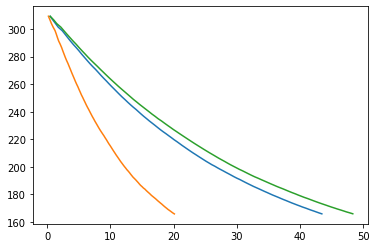

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt

from time import time

Ws = [np.array(W).copy() for _ in range(3)]
losses = [[total_loss(Ws[i], TRAIN)] for i in range(3)]
times = [[0] for i in range(3)]

for _ in range(100):
  c_time = time()
  Ws[0] = full_batch_step(0.01, Ws[0], TRAIN)
  times[0].append(time() - c_time)

  c_time = time()
  Ws[1] = mini_batch_step(0.01, Ws[1], TRAIN, 0.2)
  times[1].append(time() - c_time)

  c_time = time()
  Ws[2] = mirrored_step(0.01, Ws[2], TRAIN, 0.2, 5)
  times[2].append(time() - c_time)

  for i in range(3):
    losses[i].append(total_loss(Ws[i], TEST))


times = np.array(times).T[1:, :]
times = times.cumsum(axis=0)

losses = np.array(losses).T[1:, :]

plt.plot(times, losses)

<center>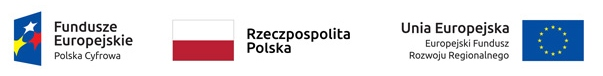</center>